In [ ]:
#import các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib

In [ ]:
#Đọc bộ dữ liệu
df = pd.read_csv('/content/diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Khám phá dữ liệu (EDA)

###
Khám phá dữ liệu để hiểu cấu trúc, các giá trị bị thiếu, phân bố của các biến và tỷ lệ lớp của biến mục tiêu ('diabetes').


In [ ]:
#Kiểm tra cấu trúc và kiểu dữ liệu của tập dữ liệu
print("DataFrame Info:")
df.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
#Lấy bản tóm tắt thống kê của các cột số trong DataFrame
print("Descriptive statistics for numerical columns:")
df.describe()

Descriptive statistics for numerical columns:


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
#Kiểm tra cấu trúc và kiểu dữ liệu của tập dữ liệu và đếm số lượng giá trị thiếu ở từng cột
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


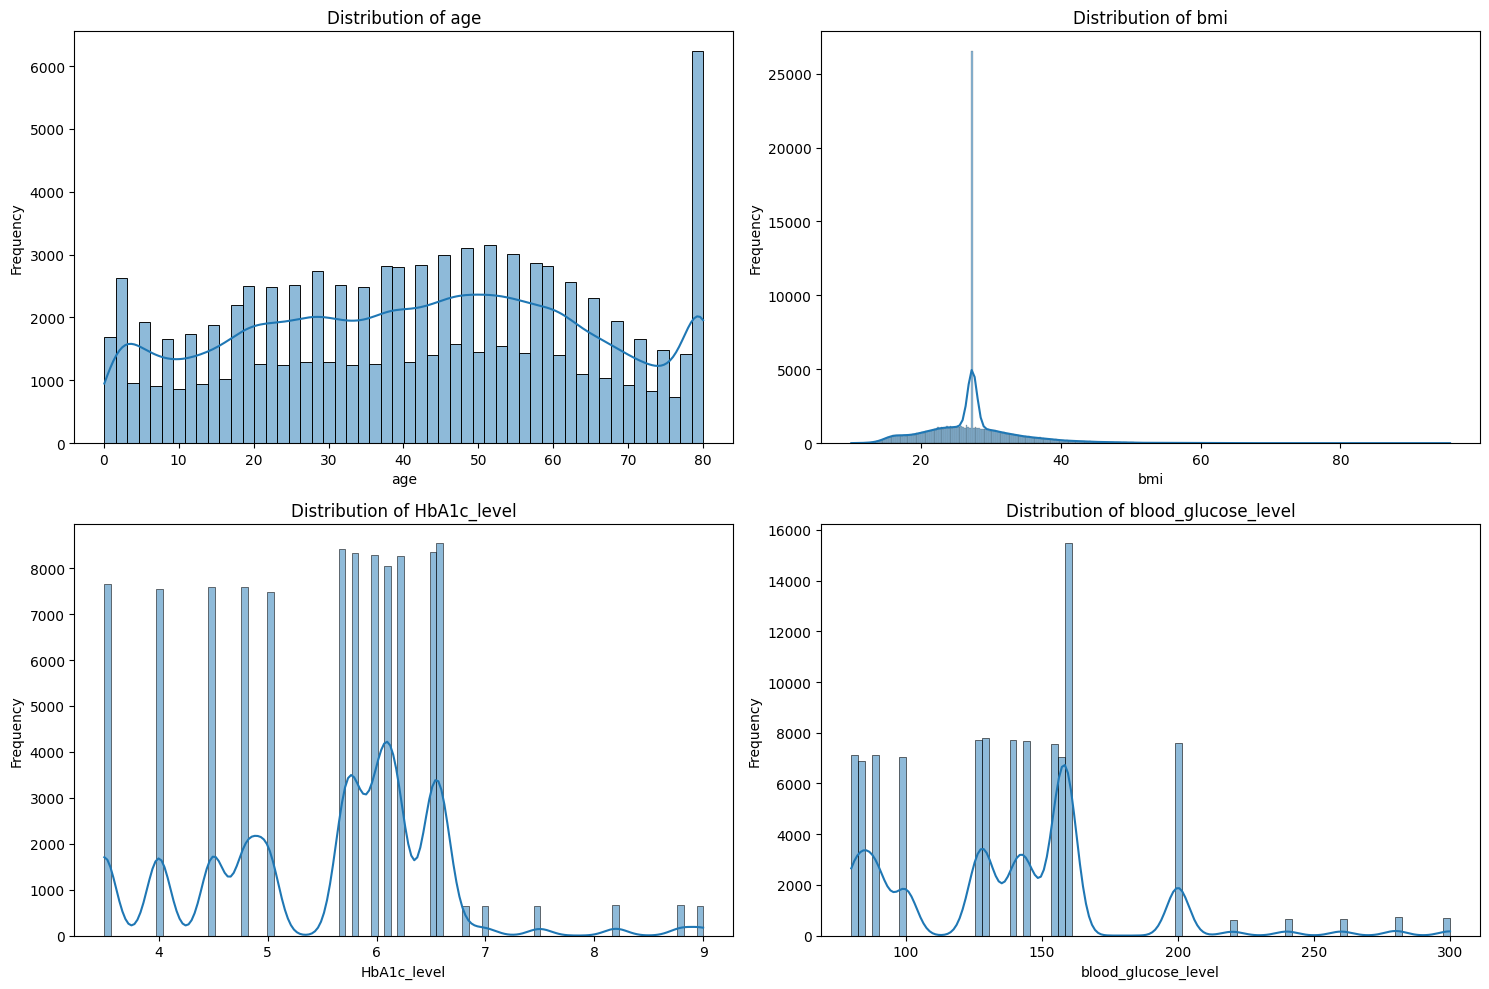

In [ ]:
#Lựa chọn các biến số liên tục để trực quan hóa bằng histogram, loại trừ các biến nhị phân do phù hợp hơn với biểu đồ tần suất
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Target variable 'diabetes' distribution:
diabetes
0    91500
1     8500
Name: count, dtype: int64


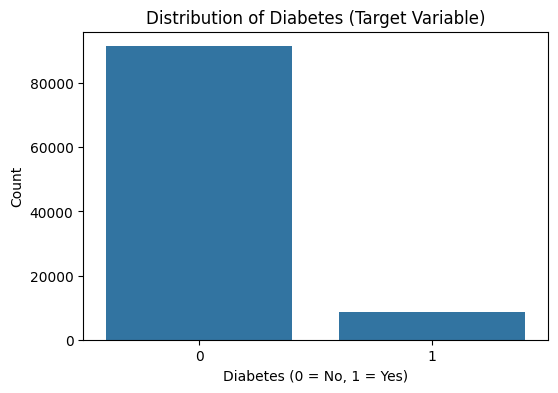

In [ ]:
#Kiểm tra sự cân bằng của biến mục tiêu diabetes
print("Target variable 'diabetes' distribution:")
print(df['diabetes'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Diabetes (Target Variable)')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Làm sạch và tiền xử lý dữ liệu


Xử lý các giá trị bị thiếu (nếu có), nhận diện và xử lý các ngoại lệ (outliers) và chuyển đổi kiểu dữ liệu cho phù hợp.


In [ ]:
# Kiểm tra các giá trị phân loại và tần suất xuất hiện của gender và smoking_history
print("Unique values and counts for 'gender':")
print(df['gender'].value_counts())
print("\nUnique values and counts for 'smoking_history':")
print(df['smoking_history'].value_counts())

Unique values and counts for 'gender':
gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

Unique values and counts for 'smoking_history':
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


**Reasoning**:
To identify and quantify potential outliers in numerical columns, I will calculate the first quartile (Q1), third quartile (Q3), and Interquartile Range (IQR) for 'age', 'bmi', 'HbA1c_level', and 'blood_glucose_level'. Then, I will determine the number and percentage of outliers based on the 1.5 * IQR rule for each column and create box plots to visualize these outliers.




Column: age
  Q1: 24.00
  Q3: 60.00
  IQR: 36.00
  Lower Bound for Outliers: -30.00
  Upper Bound for Outliers: 114.00
  Number of Outliers: 0
  Percentage of Outliers: 0.00%

Column: bmi
  Q1: 23.63
  Q3: 29.58
  IQR: 5.95
  Lower Bound for Outliers: 14.71
  Upper Bound for Outliers: 38.50
  Number of Outliers: 7086
  Percentage of Outliers: 7.09%

Column: HbA1c_level
  Q1: 4.80
  Q3: 6.20
  IQR: 1.40
  Lower Bound for Outliers: 2.70
  Upper Bound for Outliers: 8.30
  Number of Outliers: 1315
  Percentage of Outliers: 1.31%

Column: blood_glucose_level
  Q1: 100.00
  Q3: 159.00
  IQR: 59.00
  Lower Bound for Outliers: 11.50
  Upper Bound for Outliers: 247.50
  Number of Outliers: 2038
  Percentage of Outliers: 2.04%


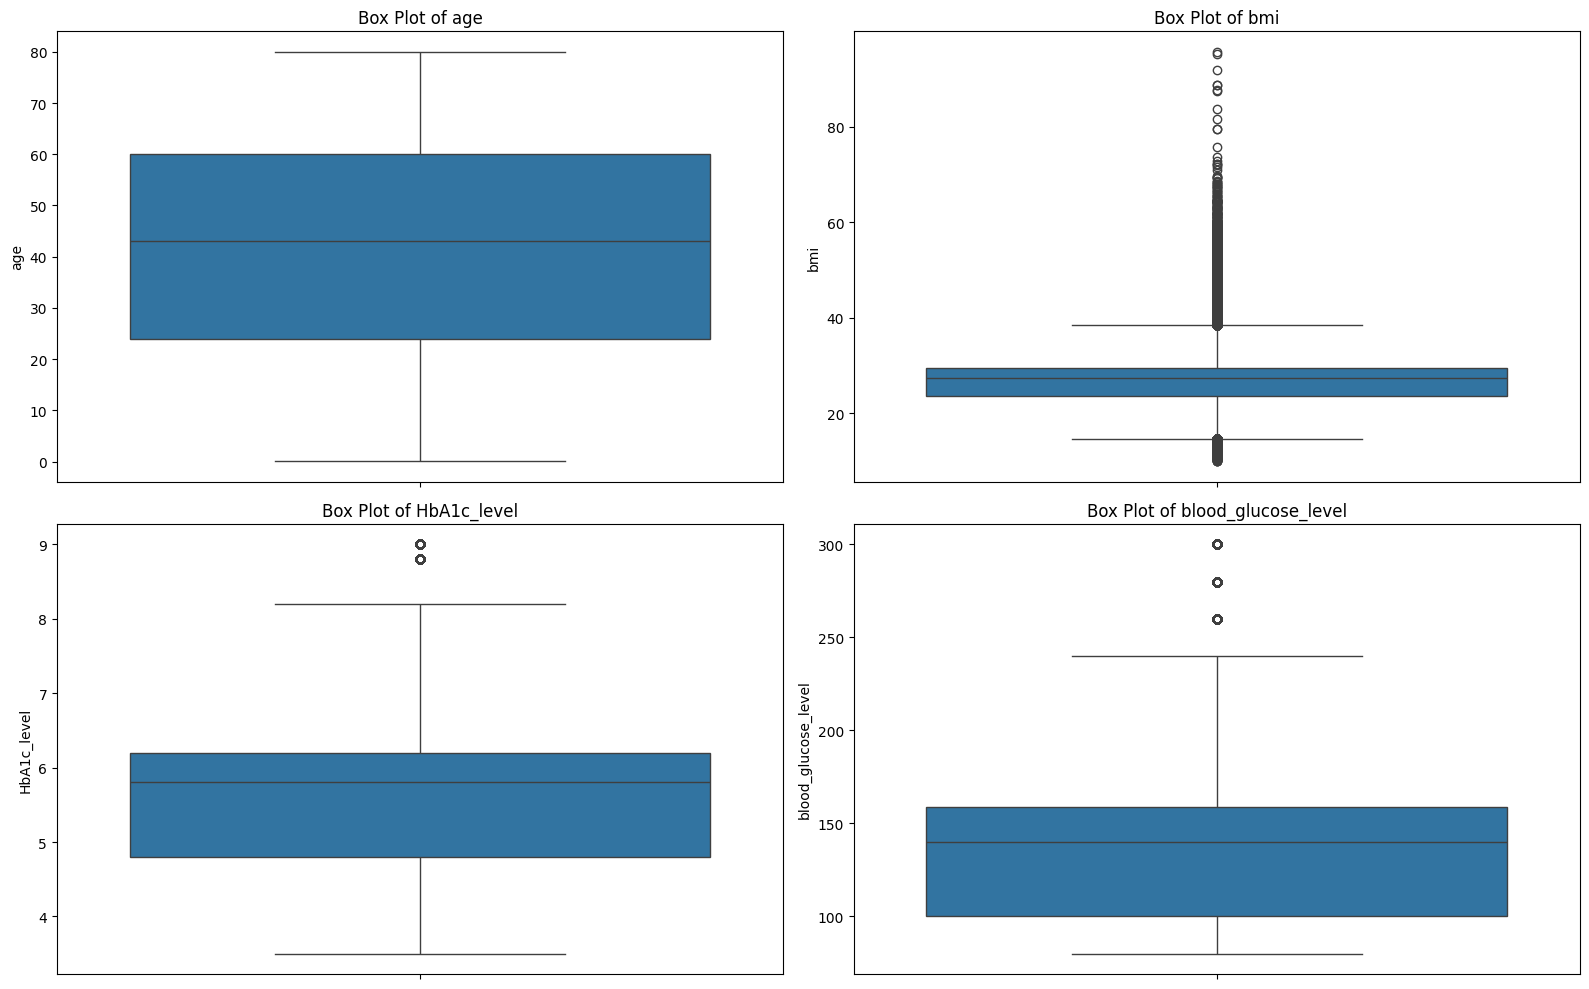

In [ ]:
#Phát hiện và trực quan hóa các giá trị ngoại lai bằng phương pháp IQR
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = len(outliers)
    percentage_outliers = (num_outliers / len(df)) * 100

    print(f"\nColumn: {col}")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Lower Bound for Outliers: {lower_bound:.2f}")
    print(f"  Upper Bound for Outliers: {upper_bound:.2f}")
    print(f"  Number of Outliers: {num_outliers}")
    print(f"  Percentage of Outliers: {percentage_outliers:.2f}%")

    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [ ]:
# Giới hạn (capping) các giá trị ngoại lai theo quy tắc 1.5 × IQR
numerical_cols_to_cap = ['bmi', 'HbA1c_level', 'blood_glucose_level']

for col in numerical_cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    print(f"Outliers in '{col}' capped between {lower_bound:.2f} and {upper_bound:.2f}")

# Re-check descriptive statistics after capping to confirm changes
print("\nDescriptive statistics after outlier capping:")
df[numerical_cols_to_cap].describe()

Outliers in 'bmi' capped between 14.71 and 38.50
Outliers in 'HbA1c_level' capped between 2.70 and 8.30
Outliers in 'blood_glucose_level' capped between 11.50 and 247.50

Descriptive statistics after outlier capping:


,bmi,HbA1c_level,blood_glucose_level
count,100000.000000,100000.000000,100000.000000
mean,26.991686,5.519624,137.387910
std,5.671428,1.047716,38.506455
min,14.705000,3.500000,80.000000
25%,23.630000,4.800000,100.000000
50%,27.320000,5.800000,140.000000
75%,29.580000,6.200000,159.000000
max,38.505000,8.300000,247.500000


In [ ]:
print("Original DataFrame shape:", df.shape)

# Chuyển đổi các biến phân loại gender và smoking_history sang dạng số bằng one-hot encoding
df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

print("New DataFrame shape after one-hot encoding:", df.shape)
print("First 5 rows of DataFrame after one-hot encoding:")
df.head()

Original DataFrame shape: (100000, 9)
New DataFrame shape after one-hot encoding: (100000, 14)
First 5 rows of DataFrame after one-hot encoding:


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140.0,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80.0,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158.0,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155.0,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155.0,0,True,False,True,False,False,False,False


# Feature Engineering

###
Chuyển đổi các biến categorical thành định dạng số, tạo các biến mới và chuẩn hóa hoặc scale các feature để chuẩn bị cho mô hình.


In [ ]:

# Xác định các cột số cần được chuẩn hóa
numerical_cols_to_scale = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Khởi tạo bộ chuẩn hóa StandardScaler
scaler = StandardScaler()

# Áp dụng fit_transform để chuẩn hóa các cột số đã chọn
df[numerical_cols_to_scale] = scaler.fit_transform(df[numerical_cols_to_scale])

print("DataFrame after scaling numerical features:")
print(df.head())
print("\nDescriptive statistics of scaled numerical features:")
print(df[numerical_cols_to_scale].describe())

DataFrame after scaling numerical features:
        age  hypertension  heart_disease       bmi  HbA1c_level  \
0  1.692704             0              1 -0.317679     1.031178   
1  0.538006             0              0  0.057889     1.031178   
2 -0.616691             0              0  0.057889     0.172162   
3 -0.261399             0              0 -0.624482    -0.495962   
4  1.515058             1              1 -1.208112    -0.686854   

   blood_glucose_level  diabetes  gender_Male  gender_Other  \
0             0.067835         0        False         False   
1            -1.490353         0        False         False   
2             0.535292         0         True         False   
3             0.457382         0        False         False   
4             0.457382         0         True         False   

   smoking_history_current  smoking_history_ever  smoking_history_former  \
0                    False                 False                   False   
1                    F

# Trực quan hóa mối tương quan

###
Vẽ biểu đồ heatmap để thể hiện sự tương quan giữa các đặc trưng với nhau và với biến mục tiêu 'diabetes'.


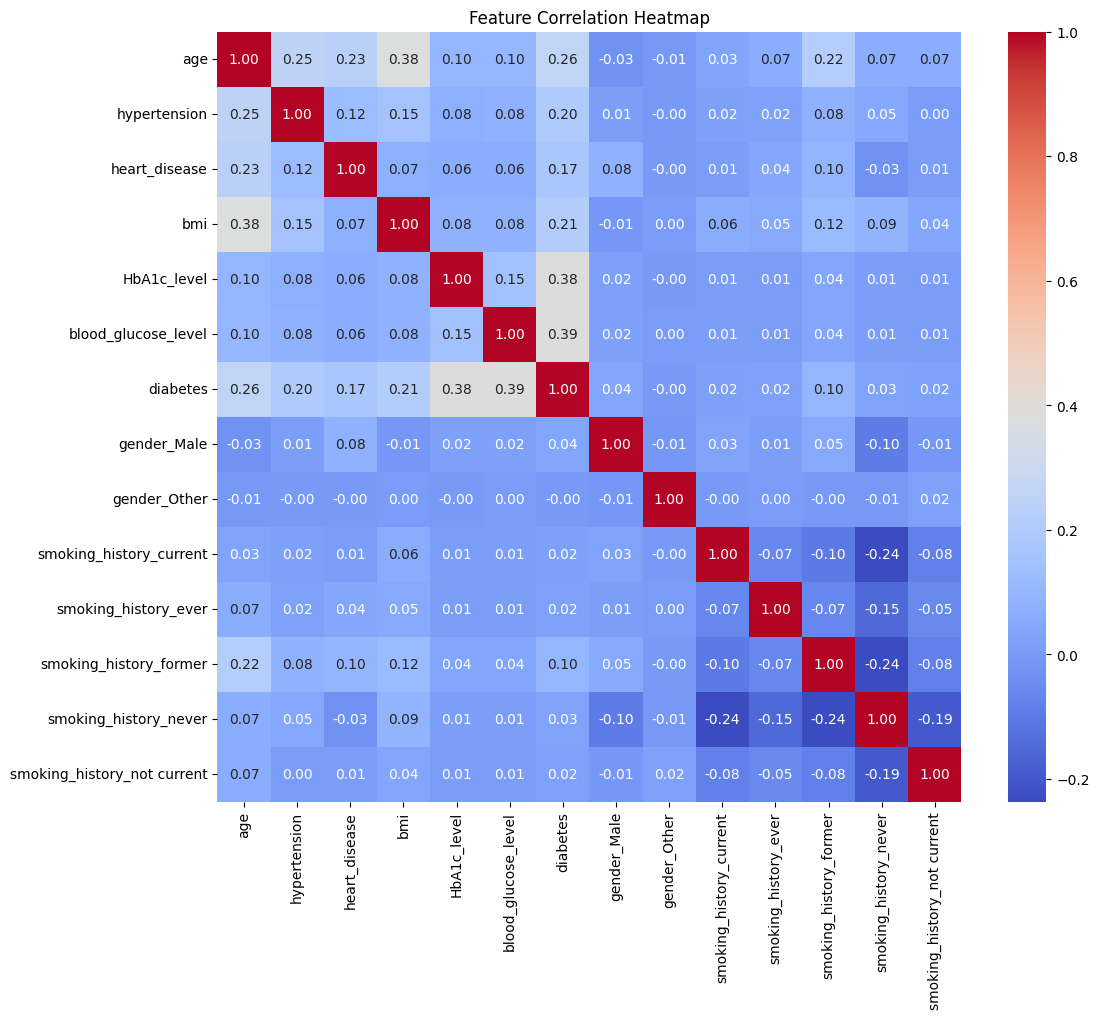

In [ ]:
# Tính ma trận tương quan giữa các biến số
correlation_matrix = df.corr(numeric_only=True)

# Vẽ biểu đồ heatmap thể hiện mối tương quan giữa các đặc trưng
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Chia dữ liệu

###
Chia tập dữ liệu thành tập huấn luyện (training set) và tập kiểm tra (testing set) để đánh giá hiệu suất của mô hình.


In [ ]:
# Xác định ma trận đặc trưng X và biến mục tiêu y
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (80000, 13)
Shape of X_test: (20000, 13)
Shape of y_train: (80000,)
Shape of y_test: (20000,)


#Xây dựng và huấn luyện pipeline cho mô hình hồi quy Logistic




In [ ]:
# Khởi tạo mô hình Logistic Regression với các tham số đã chọn
# solver='liblinear' phù hợp với tập dữ liệu nhỏ
# class_weight='balanced' giúp xử lý tình trạng mất cân bằng lớp
logistic_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

# Huấn luyện mô hình trên tập dữ liệu huấn luyện
logistic_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


#Tinh chỉnh siêu tham số



In [ ]:
# Xác định tập siêu tham số cần tinh chỉnh cho Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Khởi tạo GridSearchCV để tìm bộ siêu tham số tối ưu
# Sử dụng chỉ số F1-score do dữ liệu bị mất cân bằng lớp
grid_search = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,   # Sử dụng tất cả các lõi CPU khả dụng
    verbose=1
)

# Huấn luyện GridSearchCV trên tập dữ liệu huấn luyện
grid_search.fit(X_train, y_train)

# In ra bộ siêu tham số tốt nhất tìm được
print("Bộ siêu tham số tốt nhất:", grid_search.best_params_)

# Lưu lại mô hình Logistic Regression tốt nhất
best_logistic_model = grid_search.best_estimator_
print("Đã lưu mô hình Logistic Regression tốt nhất.")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters found: {'C': 10, 'penalty': 'l1'}
Best Logistic Regression model stored.


#Đánh giá hiệu suất của mô hình




Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93     18300
           1       0.42      0.89      0.57      1700

    accuracy                           0.89     20000
   macro avg       0.70      0.89      0.75     20000
weighted avg       0.94      0.89      0.90     20000


ROC AUC Score: 0.9618


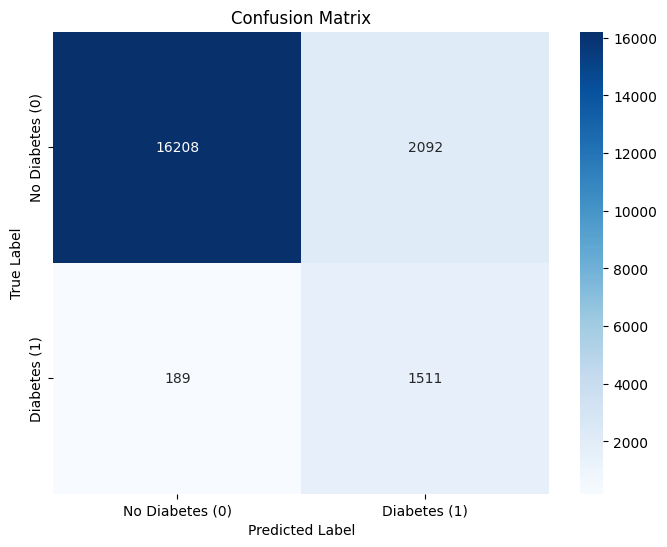

In [ ]:
# Dự đoán nhãn trên tập dữ liệu kiểm tra
y_pred = best_logistic_model.predict(X_test)

# Dự đoán xác suất thuộc lớp dương (diabetes = 1)
y_pred_proba = best_logistic_model.predict_proba(X_test)[:, 1]

# In báo cáo đánh giá mô hình (precision, recall, F1-score)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Tính và in chỉ số ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nChỉ số ROC AUC: {roc_auc:.4f}")

# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ biểu đồ heatmap cho ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Không tiểu đường (0)', 'Tiểu đường (1)'],
            yticklabels=['Không tiểu đường (0)', 'Tiểu đường (1)'])
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực tế')
plt.title('Ma trận nhầm lẫn')
plt.show()

#Lưu mô hình Logistic Regression đã được huấn luyện và tối ưu

In [ ]:
import joblib

# Định nghĩa tên file để lưu mô hình
model_filename = 'best_logistic_model.joblib'

# Lưu mô hình Logistic Regression tốt nhất
joblib.dump(best_logistic_model, model_filename)

print(f"Đã lưu thành công mô hình Logistic Regression tốt nhất với tên '{model_filename}'")


Best Logistic Regression model saved successfully as 'best_logistic_model.joblib'


## Final Task

### Subtask:
Tổng kết quá trình phân tích, các phát hiện chính từ EDA, hiệu suất của mô hình dự đoán tiểu đường và các bước tiếp theo tiềm năng.


## Summary:

### Data Analysis Key Findings

*   The dataset, comprising 100,000 entries and 9 columns, was loaded successfully with no missing values detected across any feature.
*   Initial data exploration revealed a significant class imbalance in the target variable 'diabetes': 91,500 instances (91.5%) for 'No Diabetes' and 8,500 instances (8.5%) for 'Diabetes'.
*   Outliers were identified in several numerical features: `bmi` (7.09%), `HbA1c_level` (1.31%), and `blood_glucose_level` (2.04%). These outliers were subsequently handled by capping them using the 1.5 \* IQR method.
*   Categorical features (`gender` and `smoking_history`) were successfully converted into numerical format using one-hot encoding, expanding the DataFrame from 9 to 14 columns. Numerical features (`age`, `bmi`, `HbA1c_level`, `blood_glucose_level`) were standardized using `StandardScaler`.
*   The correlation heatmap indicated various feature relationships, with `HbA1c_level` and `blood_glucose_level` showing strong positive correlations with the `diabetes` target.
*   A Logistic Regression model, configured with `class_weight='balanced'` to address class imbalance, was trained and optimized using `GridSearchCV`. The best hyperparameters identified were `C=10` and `penalty='l1'`.
*   Model evaluation on the test set revealed an overall accuracy of 0.89. While the model showed high performance for the 'No Diabetes' class (precision 0.99, recall 0.89, F1-score 0.93), its precision for the 'Diabetes' class was relatively low at 0.42, despite a high recall of 0.89. The ROC AUC score was robust at 0.9618.
*   The trained and optimized Logistic Regression model was successfully saved as 'best_logistic_model.joblib' for future use.

### Insights or Next Steps

*   **Address Class Imbalance Further**: While `class_weight='balanced'` helped, the low precision (0.42) for the 'Diabetes' class suggests that the model still produces a significant number of false positives. Investigating more advanced techniques like SMOTE or exploring different sampling strategies during training could further improve the model's ability to correctly identify diabetic cases without sacrificing precision.
*   **Explore Alternative Models**: Given the moderate performance for the minority class, it would be beneficial to explore more complex models such as Gradient Boosting Machines (e.g., XGBoost, LightGBM) or Random Forests. These models often handle complex relationships and class imbalances differently and might yield better overall predictive performance and a more balanced precision/recall trade-off for the diabetic class.
